In [1]:
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
# import dask
# import dask.distributed
# import ncar_jobqueue
import esmlab
import esmlab_regrid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import default_fillvals
import pop_tools 

import config

import warnings
from datetime import date, datetime, timezone


### Prep work
set up directory with original and destination grid files in it

In [2]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/kristenk/esmlab-regrid'

In [3]:
method = 'conservative'
src_grid = 'latlon_1x1_180W'
dst_grid = 'POP_gx1v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)

/glade/work/kristenk/esmlab-regrid
/glade/work/kristenk/esmlab-regrid


In [4]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.431e+12 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0

### Interpolate satellite-derived NPP on POP grid 

In [6]:
npp_file = '/glade/work/kristenk/satellite_data/processed/NPP_3methodmean_mean2003to2017_1deg.nc'

In [7]:
ds_sat=xr.open_dataset(npp_file, decode_times=False)

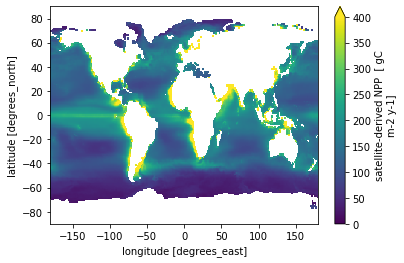

In [10]:
ds_sat.NPP.plot(vmin=0,vmax=400)

### Regrid laterally

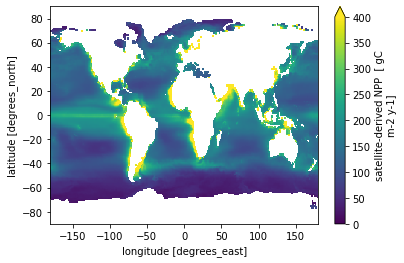

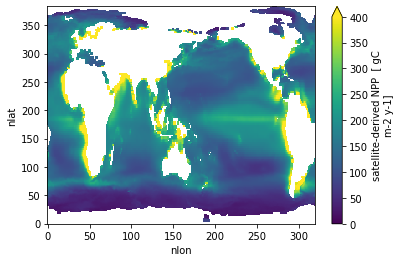

In [13]:
dso_lateral = xr.Dataset()
v='NPP'
dso_lateral[v] = regrid_operator(ds_sat[v], renormalize=True)  #, apply_mask=True) #commented out apply_mask (get an error)
dso_lateral[v].attrs = ds_sat[v].attrs

dso_lateral = dso_lateral.rename({'lon': 'nlon', 'lat': 'nlat'})

plt.figure()
ds_sat[v].plot(vmin=0,vmax=400)

plt.figure()
dso_lateral[v].plot(vmin=0,vmax=400);

### Apply missing values mask to the newly interpolated data
First make a mask

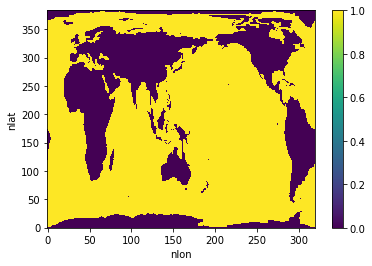

In [14]:
nj, ni = ds_dst.KMT.shape

# make 3D array of 0:km
ONES_2d = xr.DataArray(np.ones((nj, ni)), dims=('nlat', 'nlon'))
#ZERO_TO_KM = (zero_to_km * ONES_2d)


# # mask out cells where k is below KMT
MASK = ONES_2d.where(ONES_2d < ds_dst.KMT)
MASK = xr.where(MASK.notnull(), True, False)

MASK.plot()

Then apply the mask

In [18]:
dso_lateral[v] = dso_lateral[v].where(MASK)

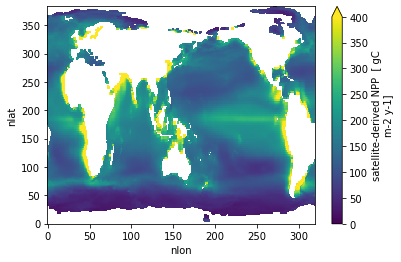

In [20]:
plt.figure()
dso_lateral[v].plot(vmin=0,vmax=400)

### Lateral smoothing operation

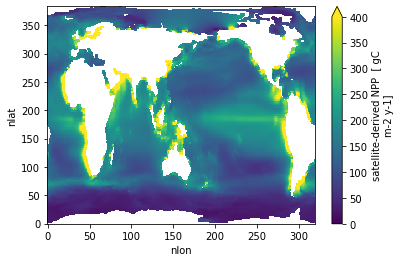

In [24]:
# loop over variables
dso_smooth = xr.Dataset()  
    
# apply lateral smooth
dso_smooth[v] = pop_tools.lateral_fill(dso_lateral[v].copy(), MASK, ltripole=ltripole)
dso_smooth[v].attrs = dso_lateral[v].attrs

dso_smooth.NPP.plot(vmin=0,vmax=400)

### Get the dataset ready to write out

In [25]:
dso = dso_smooth.copy()

dso[v].encoding['_FillValue'] = default_fillvals['f4']
dso[v].encoding['dtype'] = np.float32
dso[v].attrs['coordinates'] = 'TLONG TLAT'

if '_FillValue' not in dso[v].encoding:
    dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    NPP      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    history:  created by kristen krumhardt on 2019-10-16

In [26]:
#!ncdump -h /glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc

In [27]:
#file_out = f'{config.dirout}/marbl_jan_ic_woa_{dst_grid}.c{datestamp}.nc'
file_out = '/glade/work/kristenk/satellite_data/POP_regrid/NPP_3methodmean_mean2003-2017_POPgrid.nc'
dso.to_netcdf(file_out)

## Satellite-derived PIC

In [5]:
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'

In [7]:
ds_sat=xr.open_dataset(pic_file, decode_times=False)

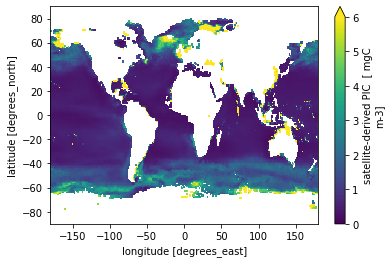

In [11]:
ds_sat.PIC.plot(vmin=0,vmax=6)

### Regrid laterally

/glade/work/kristenk/miniconda/envs/analysis2/lib/python3.7/site-packages/esmlab_regrid/core.py:203: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0.0, data_dst, np.nan)


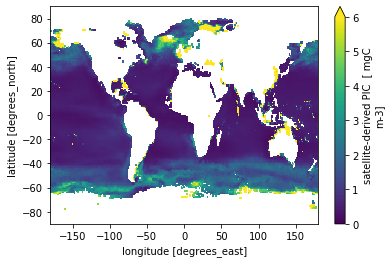

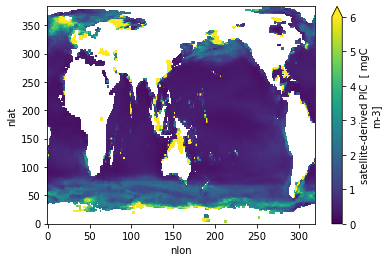

In [12]:
dso_lateral = xr.Dataset()
v='PIC'
dso_lateral[v] = regrid_operator(ds_sat[v], renormalize=True)  #, apply_mask=True) #commented out apply_mask (get an error)
dso_lateral[v].attrs = ds_sat[v].attrs

dso_lateral = dso_lateral.rename({'lon': 'nlon', 'lat': 'nlat'})

plt.figure()
ds_sat[v].plot(vmin=0,vmax=6)

plt.figure()
dso_lateral[v].plot(vmin=0,vmax=6);

In [15]:
dso_lateral[v] = dso_lateral[v].where(MASK)

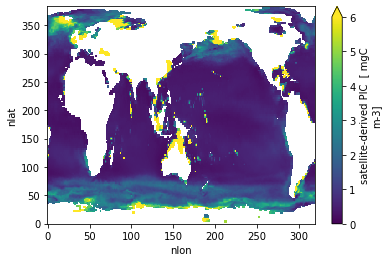

In [18]:
dso_lateral[v].plot(vmin=0,vmax=6)

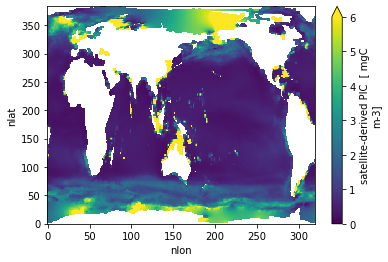

In [16]:
dso_smooth = xr.Dataset()  
    
# apply lateral smooth
dso_smooth[v] = pop_tools.lateral_fill(dso_lateral[v].copy(), MASK, ltripole=ltripole)
dso_smooth[v].attrs = dso_lateral[v].attrs

dso_smooth.PIC.plot(vmin=0,vmax=6)

It looks weird to fill in the Nans in the Arctic so I will write out the unsmoothed data, dso_lateral

In [19]:
#dso = dso_smooth.copy()
dso = dso_lateral.copy()
dso[v].encoding['_FillValue'] = default_fillvals['f4']
dso[v].encoding['dtype'] = np.float32
dso[v].attrs['coordinates'] = 'TLONG TLAT'

if '_FillValue' not in dso[v].encoding:
    dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    PIC      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    history:  created by kristen krumhardt on 2019-10-17

In [20]:
file_out = '/glade/work/kristenk/satellite_data/POP_regrid/PIC_mean2003-2018_POPgrid.nc'
dso.to_netcdf(file_out)

### Do monthly climatology for Chl

In [5]:
chl_file = '/glade/work/kristenk/satellite_data/Monthly_clim_chlor_a/A20031522020182.L3m_MC_CHL_chlor_a_9km.nc'

In [7]:
ds_sat=xr.open_dataset(chl_file, decode_times=False)

In [9]:
ds_sat

<xarray.Dataset>
Dimensions:  (eightbitcolor: 256, lat: 2160, lon: 4320, rgb: 3)
Coordinates:
  * lat      (lat) float32 89.958336 89.875 89.791664 ... -89.87501 -89.958336
  * lon      (lon) float32 -179.95833 -179.875 ... 179.87502 179.95834
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes:
    product_name:                      A20031522020182.L3m_MC_CHL_chlor_a_9km.nc
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    17-year
    processing_version:                2018.1
    date_created:                      2020-08-13T09:52:09.000Z
    history:                           l3mapgen par=A20031522020182.L3m_MC_CH...
    l2_flag_names:              

In [10]:
dso_lateral = xr.Dataset()
v='chlor_a'
dso_lateral[v] = regrid_operator(ds_sat[v], renormalize=True)  #, apply_mask=True) #commented out apply_mask (get an error)
dso_lateral[v].attrs = ds_sat[v].attrs

dso_lateral = dso_lateral.rename({'lon': 'nlon', 'lat': 'nlat'})

plt.figure()
ds_sat[v].plot()

plt.figure()
dso_lateral[v].plot();

ValueError: dimension mismatch